## 1. Environment Setup and Imports
Ensure we're using the correct kernel and loading utils from the `src/` directory.

In [4]:
import sys, os
sys.path.append(os.path.abspath("../src"))

# Torch & GNN
import torch
from torch_geometric.nn import SAGEConv

# Custom modules (fully modularized)
from load_elliptic_data import load_and_preprocess_elliptic_data
from data_utils_randomsplit import random_split
from model_sage import GraphSAGENet
from train_utils import set_seed, train_full, save_config
from evaluation_randomsplit import compute_metrics
from config import SEEDS

print("All modules imported successfully.")


All modules imported successfully.


## 2. Load and Preprocess the Elliptic Dataset + Seed
This loads the data, maps transaction IDs to node indices, filters isolated nodes, and normalizes node features.


In [5]:
# Load preprocessed Elliptic data
data = load_and_preprocess_elliptic_data("../elliptic_bitcoin_dataset")
print(data)


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])


## 3. Initialize the GCN Model
Set hyperparameters and move model/data to GPU/CPU if available.

In [7]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (can be saved into config later)
hidden_channels = 8
dropout = 0.3
out_channels = 2
in_channels = data.x.shape[1]

# Model initialization
model = GraphSAGENet(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    dropout=dropout
).to(device)

data = data.to(device)
print(model)


GraphSAGENet(
  (conv1): SAGEConv(166, 8, aggr=mean)
  (conv2): SAGEConv(8, 2, aggr=mean)
)


# 4. Initialize and Train the GraphSAGE Model

This step creates the GraphSAGE architecture and moves it to the appropriate device. The model is defined in `src/model_sage.py`.


In [5]:
from train_multiseed import train_and_evaluate_multiseed
from config import SEEDS

for seed in SEEDS:
    print(f"Running seed {seed}...")
    train_and_evaluate_multiseed(seed, data, model_type="SAGE")


Running seed 42...
Epoch 001 | Loss: 0.7191 | Val Acc: 0.7245 | Val F1: 0.5279
Epoch 002 | Loss: 0.6182 | Val Acc: 0.7963 | Val F1: 0.5710
Epoch 003 | Loss: 0.5285 | Val Acc: 0.8387 | Val F1: 0.6001
Epoch 004 | Loss: 0.4712 | Val Acc: 0.8637 | Val F1: 0.6133
Epoch 005 | Loss: 0.4292 | Val Acc: 0.8806 | Val F1: 0.6218
Epoch 006 | Loss: 0.3948 | Val Acc: 0.8938 | Val F1: 0.6249
Epoch 007 | Loss: 0.3715 | Val Acc: 0.9006 | Val F1: 0.6169
Epoch 008 | Loss: 0.3489 | Val Acc: 0.9047 | Val F1: 0.6070
Epoch 009 | Loss: 0.3294 | Val Acc: 0.9052 | Val F1: 0.5920
Epoch 010 | Loss: 0.3163 | Val Acc: 0.9054 | Val F1: 0.5814
Epoch 011 | Loss: 0.3028 | Val Acc: 0.9059 | Val F1: 0.5715
Epoch 012 | Loss: 0.2920 | Val Acc: 0.9060 | Val F1: 0.5655
Epoch 013 | Loss: 0.2823 | Val Acc: 0.9063 | Val F1: 0.5617
Epoch 014 | Loss: 0.2744 | Val Acc: 0.9064 | Val F1: 0.5576
Epoch 015 | Loss: 0.2660 | Val Acc: 0.9063 | Val F1: 0.5559
Epoch 016 | Loss: 0.2612 | Val Acc: 0.9075 | Val F1: 0.5593
Epoch 017 | Loss: 0.2

## 5. Evaluation and Visualization

### 5.1 Setup and Imports

In [1]:
import sys
sys.path.append("../src")

from evaluation_pipeline import (
    run_inference_all_seeds,
    plot_conf_matrices,
    summarize_classification_report,
    save_fp_fn_indices,
    attach_node_times,
    plot_fp_fn_time_distributions
)

from analysis_utils import (
    load_metrics_across_seeds,
    aggregate_metrics_table,
    plot_loss_curve
)

from model_sage import GraphSAGENet
from load_elliptic_data import load_and_preprocess_elliptic_data

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seeds = [42, 123, 777, 2023, 31415]

# Load model + data
data = load_and_preprocess_elliptic_data("../elliptic_bitcoin_dataset").to(device)
model_class = GraphSAGENet
model_dir = "../models_v2/SAGE"


### 5.2 Load Metric Logs and Plot Loss

,Metric,Mean,Std,Formatted
0,val_acc,0.9752,0.0010,0.9752 ± 0.0010
1,val_f1_macro,0.9251,0.0031,0.9251 ± 0.0031
2,val_f1_illicit,0.9864,0.0005,0.9864 ± 0.0005


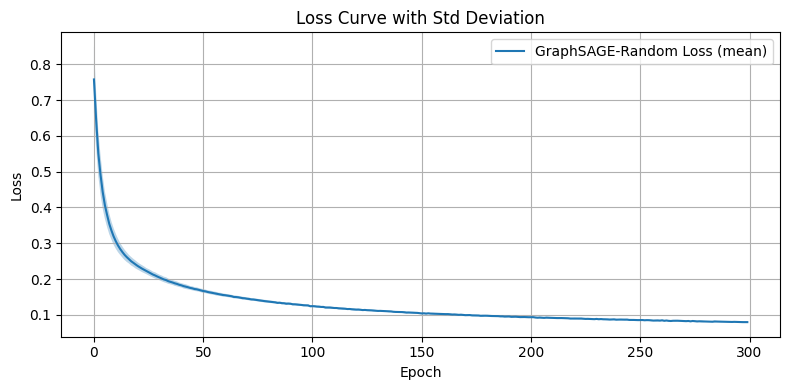

In [8]:
metrics_logs = load_metrics_across_seeds(model_dir, ["val_acc", "val_f1_macro", "val_f1_illicit", "loss"])
summary_df = aggregate_metrics_table(metrics_logs)
display(summary_df)
plot_loss_curve(metrics_logs["loss"], label="GraphSAGE-Random Loss")

### 5.3 Inference Across Seeds

In [3]:
y_true_all, y_pred_all, y_proba_all, seed_metrics = run_inference_all_seeds(
    model_dir=model_dir,
    model_class=model_class,
    data=data,
    seeds=seeds
)

### 5.4 Confusion Matrices

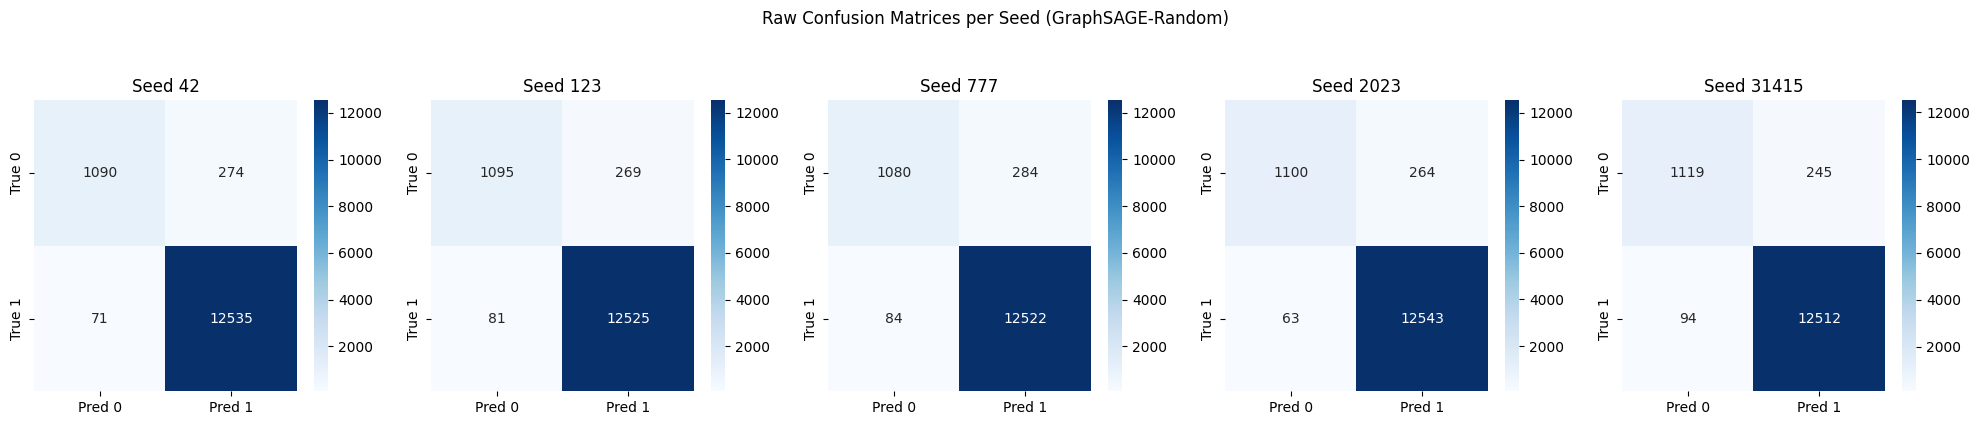

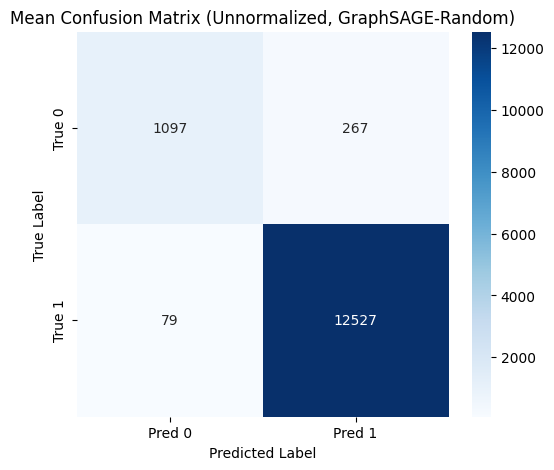

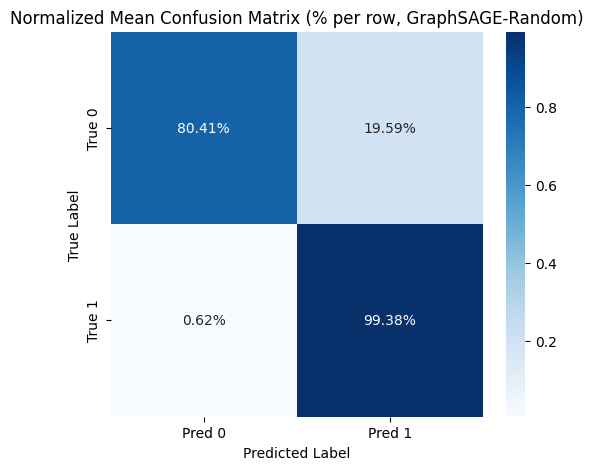

In [9]:
plot_conf_matrices(y_true_all, y_pred_all, seeds, model_name="GraphSAGE-Random")

### 5.5 Metric Summary Across Seeds

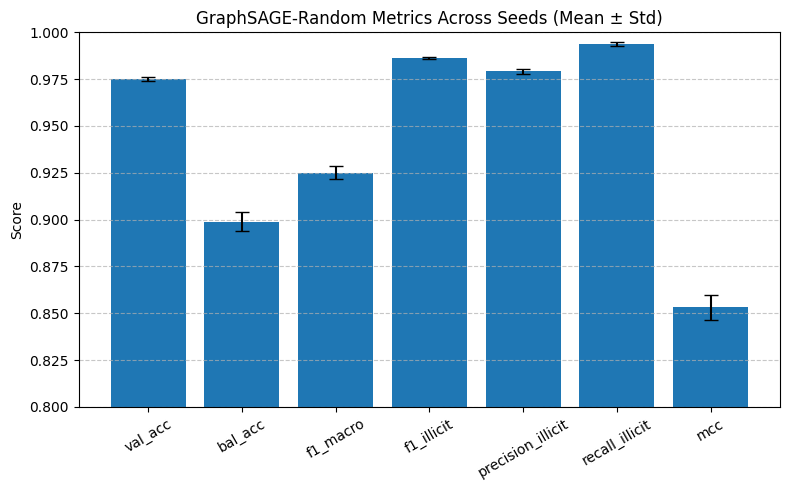

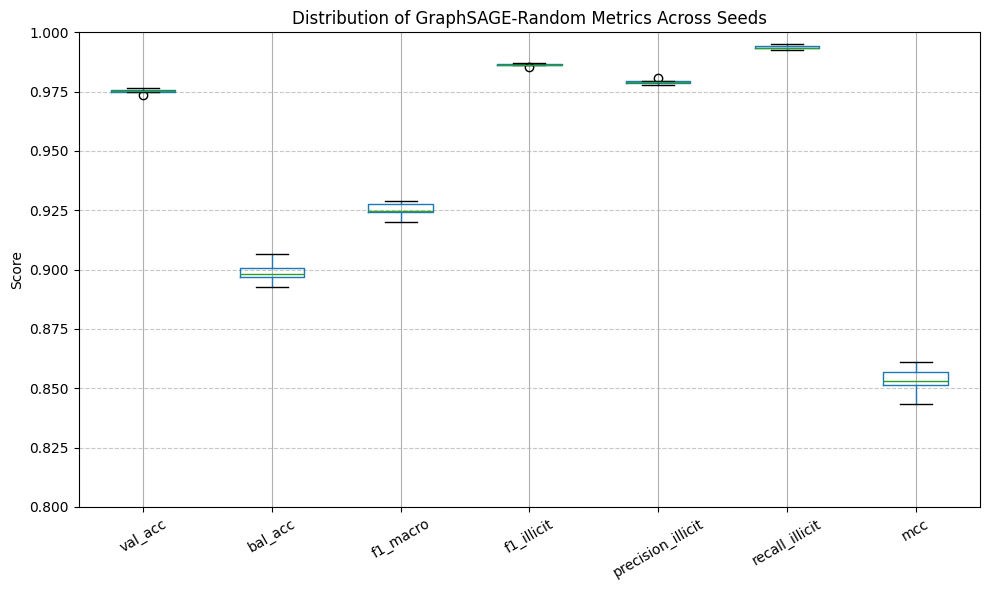

,Metric,Mean,Std,Formatted
0,val_acc,0.9752,0.0011,0.9752 ± 0.0011
1,bal_acc,0.8989,0.0051,0.8989 ± 0.0051
2,f1_macro,0.9251,0.0034,0.9251 ± 0.0034
3,f1_illicit,0.9864,0.0006,0.9864 ± 0.0006
4,precision_illicit,0.9791,0.0011,0.9791 ± 0.0011
5,recall_illicit,0.9938,0.0009,0.9938 ± 0.0009
6,mcc,0.8532,0.0067,0.8532 ± 0.0067


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Inject val_acc into each seed’s metric dictionary
val_acc_list = metrics_logs["val_acc"]
for i in range(len(seed_metrics)):
    seed_metrics[i]["val_acc"] = val_acc_list[i]

df = pd.DataFrame(seed_metrics)
main_metrics = ['val_acc', 'bal_acc', 'f1_macro', 'f1_illicit', 'precision_illicit', 'recall_illicit', 'mcc']

means = df[main_metrics].mean()
stds = df[main_metrics].std()

plt.figure(figsize=(8, 5))
plt.bar(main_metrics, means, yerr=stds, capsize=5)
plt.ylim(0.80, 1.0)
plt.title("GraphSAGE-Random Metrics Across Seeds (Mean ± Std)")
plt.xticks(rotation=30)
plt.ylabel("Score")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
df[main_metrics].boxplot()
plt.ylim(0.80, 1.0)
plt.title("Distribution of GraphSAGE-Random Metrics Across Seeds")
plt.xticks(rotation=30)
plt.ylabel("Score")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

summary_table = pd.DataFrame({
    "Metric": main_metrics,
    "Mean": means.round(4).values,
    "Std": stds.round(4).values,
    "Formatted": [f"{m:.4f} ± {s:.4f}" for m, s in zip(means, stds)]
}).set_index("Metric").loc[main_metrics].reset_index()

display(summary_table)


### 5.6 Class-Wise Breakdown

In [11]:
summarize_classification_report(y_true_all, y_pred_all)


Legit (0) Metrics:
precision: 0.9332 ± 0.0082
recall: 0.8041 ± 0.0095
f1-score: 0.8638 ± 0.0056

Illicit (1) Metrics:
precision: 0.9791 ± 0.0010
recall: 0.9938 ± 0.0008
f1-score: 0.9864 ± 0.0005


### 5.7 FP/FN Indices

In [12]:
save_fp_fn_indices(y_true_all, y_pred_all, seeds, model_dir)

### 5.8 FP/FN Time Analysis (Raw + Normalised)

In [13]:
data = attach_node_times(data, "../elliptic_bitcoin_dataset/elliptic_txs_features.csv")

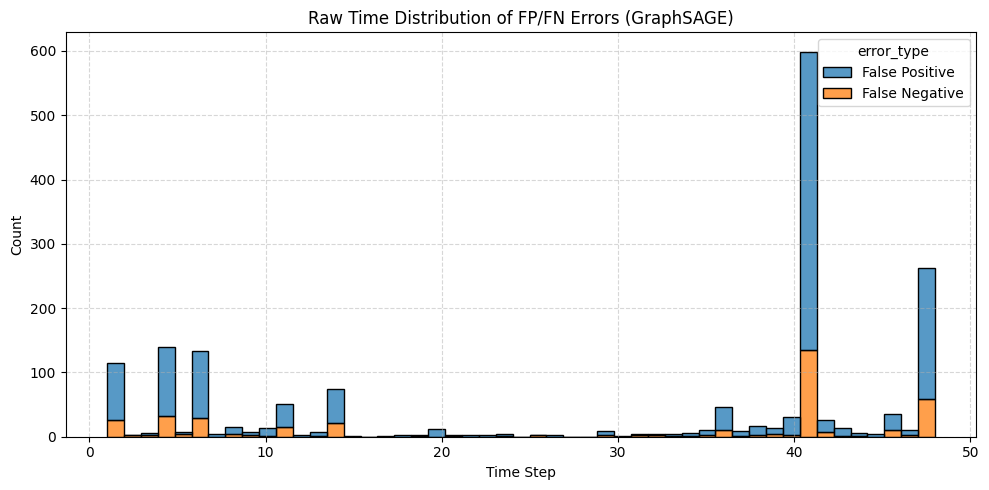

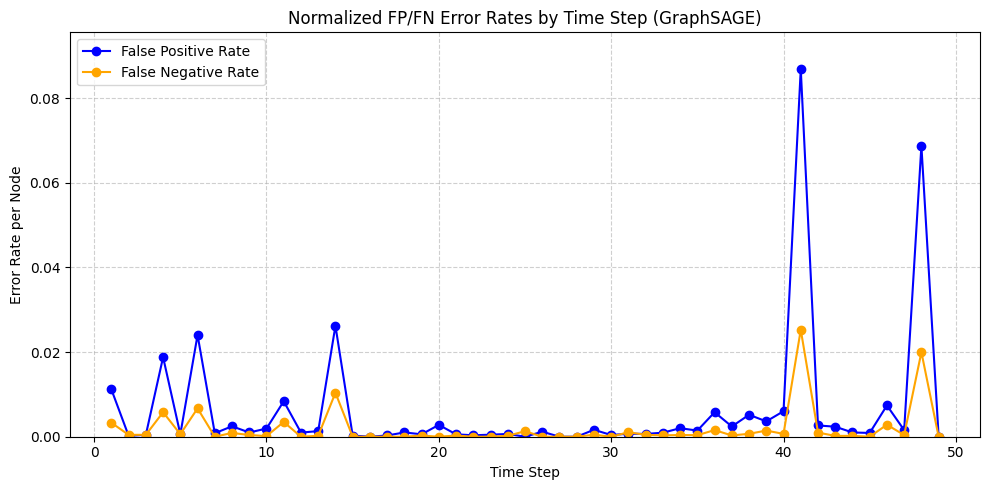

In [14]:
plot_fp_fn_time_distributions(data, seeds, model_dir, model_name="GraphSAGE")

## 6. Export to JSON

In [ ]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from evaluation_pipeline import export_full_evaluation_to_json

# --------------------------------------------
# Reconstruct confusion matrices (per seed)
# --------------------------------------------
conf_matrices = [
    confusion_matrix(y_true_all[i], y_pred_all[i])
    for i in range(len(seeds))
]

# --------------------------------------------
# Reconstruct FP/FN counts + time distributions
# using saved indices and timestamps
# --------------------------------------------
model_dir = "../models_v2/SAGE"  # <-- change per model
fp_counts, fn_counts = [], []
fp_time_all, fn_time_all = [], []

timestamps = data.node_times.cpu().numpy()

for seed in seeds:
    base = os.path.join(model_dir, f"seed_{seed}")
    fp_idx = np.load(os.path.join(base, "fp_indices.npy"))
    fn_idx = np.load(os.path.join(base, "fn_indices.npy"))

    fp_counts.append(len(fp_idx))
    fn_counts.append(len(fn_idx))

    fp_time_all.extend(timestamps[fp_idx])
    fn_time_all.extend(timestamps[fn_idx])

# Convert to JSON-compatible native Python types
fp_time_all = [int(t) for t in fp_time_all]
fn_time_all = [int(t) for t in fn_time_all]

# --------------------------------------------
# Final export to JSON files
# --------------------------------------------
export_full_evaluation_to_json(
    seed_metrics=seed_metrics,
    conf_matrices=conf_matrices,
    fp_counts=fp_counts,
    fn_counts=fn_counts,
    fp_time_all=fp_time_all,
    fn_time_all=fn_time_all,
    output_dir=model_dir
)
